In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import optimize
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output
from scipy.stats import chisquare


%matplotlib inline


In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [73]:
cd /Users/austinmcdonald/Desktop/test/cut/Ca/1Spot3/

/Users/austinmcdonald/Desktop/test/cut/Ca/1Spot3


In [74]:
files = os.listdir()
files = [x for x in files if x != '.DS_Store']
#files[0:10]
#files = files[1:]
#files = files[0:150]
#files

In [75]:
eCoeff = 0.01160
eOffset= 1917
SpotInfo2 = []
AllPairs =[]
Shape = 221
Row = int(4) # define the area to take around the spots
Col = int(4) # define the area to take around the spots
xvs = np.arange(0,Shape)
#DataS=np.zeros(Shape**2).reshape((Shape,Shape))
neighborhood_size = 9

DataSub = np.zeros(Shape**2).reshape((Shape,Shape))

eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))

    
MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
for x in range(700,750):
    Images = np.array(Image.open(files[x]))
    Images = eCoeffM*(Images - eOffsetM) ######################################## 
    ImageFit = []
    for y in range(0,Shape):
        coefs = poly.polyfit(xvs,Images[y], 2) # fits 11th order poly 
        ffit  = poly.polyval(xvs, coefs)
        ImageFit.append(ffit)
    MeanFit+=np.array(ImageFit)
MeanFit = MeanFit/50

for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])) )###################### - MeanFit
    Images = eCoeffM*(Images - eOffsetM) - MeanFit ######################################## 
    DataSub += Images


data = DataSub

threshold = np.mean(data)+3*np.std(data)

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
Pairs = []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)
    Pairs.append((x_center,y_center))
for item in Pairs:
    if item not in AllPairs:
        AllPairs.append(item) 
        
clear_output()
print('Finding AllPairs')
print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))   
Images = None
ImageB = None
#data   = None
Slices = None
labeled= None
num_objects=None
    
############################################################## 


Xc=[]
Yc=[]
for qw in range(0,len(AllPairs)):
    XX = AllPairs[qw][0]
    YY = AllPairs[qw][1]
    if XX>10 and XX<210 and YY>10 and YY<210:
        Xc.append(XX)
        Yc.append(YY)


for q in range(0,len(files)):
    Images = (np.array(Image.open(files[q])) )#- MeanFit)################### 
    Images = eCoeffM*(Images - eOffsetM) - MeanFit ######################################## 
    Images[Images<0]=0
    SpotInfoHolder = []

    
    for w in range(0,len(Xc)):
        Xindex = int(Xc[w])
        Yindex = int(Yc[w])
        spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
        spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
        spot = spot1[2:7,2:7]
        SpotRemove = np.zeros(5**2).reshape((5,5))
        spot2[2:7,2:7]=SpotRemove
        spotB = spot2

        ATot = spot.sum()
        ATotB = spot2.sum()
        SpotInfo2.append([q,Xindex,Yindex,ATot,ATotB])
        
    clear_output()
    print('Finding all areas') 
    print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))
##############################################################
##############################################################
##############################################################
Par = len(AllPairs)
AVG = 5
Mnumb = 10
PairsMade=[]
Tau = []
Signal = []
for x in range(0,Par):
    HoldArea = np.array(SpotInfo2[x::Par])[:,3]
    HoldAreaB = np.array(SpotInfo2[x::Par])[:,4]*(25/56)
    aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))/AVG
    aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))/AVG
    vals =np.arange(0,len(aa))

    coefs = poly.polyfit(vals,aaB, 3)
    ffit  = poly.polyval(vals, coefs)
    Sig = np.array(aa-ffit)
                                
    meanI = np.mean(Sig[:Mnumb])
    sigmaI = np.std(Sig[:Mnumb])
    meanE = np.mean(Sig[-Mnumb:])
    sigmaE = np.std(Sig[-Mnumb:])
    meanM = np.mean(Sig)
    T = len(Sig)
    tau = ((meanM - meanE)/(meanI -meanE))*T
    Tau.append(tau)
    Signal.append(Sig)

Tau2 = []
Offset = 5
for x in range(0,Par):
    TauH = Tau[x]
    for q in range(0,50):
        meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
        meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
        T = len(Signal[x])
        meanM = np.mean(Signal[x])
        tau = ((meanM - meanE)/(meanI -meanE))*T 
        if tau != tau:
            tau = -10
        TauH = tau
    Tau2.append(TauH)
    
    
Tau3 = []
Offset = 3
for x in range(0,Par):
    TauH = Tau2[x]
    for q in range(0,50):
        meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
        meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
        T = len(Signal[x])
        meanM = np.mean(Signal[x])
        tau = ((meanM - meanE)/(meanI -meanE))*T 
        if tau != tau:
            tau = -10
        TauH = tau
    Tau3.append(TauH)
    
##############################################################  
##############################################################  
############################################################## 
data = []
PairsMade = []
chiF = []
chiB = []
chiFIT=[]
chiRa = []
meanDif = []
Dtau = []

Offset =3
for x in range(0,Par):
    TauH   = Tau3[x]
    Data = running_mean(Signal[x],4)
    DataLeft  = Data[:int(TauH)-Offset]
    DataRight = Data[int(TauH)+Offset:]
    sigma = np.std(Data)
    mean  = np.mean(Data)
    meanI  = np.mean(DataLeft)
    sigmaI = np.std(DataLeft)
    meanE  = np.mean(DataRight)
    sigmaE = np.std(DataRight)
    Inten  = Signal[x][:int(TauH)]
    Intensity  = np.sum(Inten)/len(Inten)

    chiHIGH = np.sum((DataLeft - np.mean(DataLeft))**2)
    chiLOW = np.sum((DataRight - np.mean(DataRight))**2)
    
    val = np.arange(0,len(Data),1)
    fit=np.polyfit(val,Data,1)    
    chiFit  = np.sum((np.polyval(fit, val) - Data) ** 2)
    
    dtau = TauH*np.sqrt(((sigma-sigmaE)/(mean-meanE))**2+((sigmaI-sigmaE)/(meanI-meanE))**2)
    if  True:#meanI-2*sigmaI > meanE+2*sigmaE and TauH>0:
        data.append([Signal[x],TauH,Intensity])
        PairsMade.append(AllPairs[x])
        chiF.append(chiHIGH)
        chiB.append(chiLOW)
        chiFIT.append(chiFit)
        chiRa.append((chiLOW+chiHIGH)/ chiFit)
        meanDif.append(meanI-meanE)
        Dtau.append(dtau)
   


Finding all areas
On file 750 of 750


//anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
//anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [76]:
len(AllPairs)

119

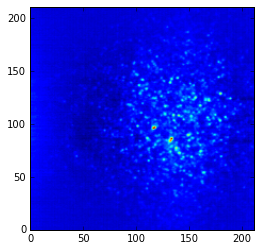

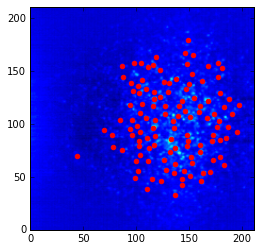

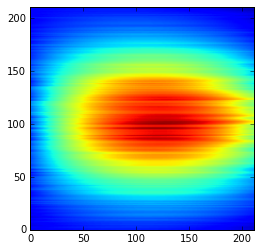

In [77]:
dd=np.array(DataSub)
plt.imshow(dd)
plt.xlim(0,211)
plt.ylim(0,211)
plt.show()
plt.imshow(dd)
plt.xlim(0,211)
plt.ylim(0,211)
plt.scatter(Xc,Yc,color='r')
plt.show()
tt = np.array(MeanFit)
plt.imshow(tt)
plt.xlim(0,211)
plt.ylim(0,211)
plt.show()

In [78]:
vals =np.arange(0,len(data[0][0]))
#vals = np.add.reduceat(vals2, np.arange(0, len(vals2), AVG))
K=4
for x in range(0,len(data)):
    if meanDif[x]>20 :#and chiRa[x]<1.2:
        plt.figure(figsize=(15,6))
        #plt.title(x,fontsize=20)
        print('Chi ratio = ',chiRa[x])
        print('tau =', str(data[x][1])+' '+"+/-"+' '+str(Dtau[x]/7.75))
        TauH   = Tau3[x]
        Data = running_mean(Signal[x],4)
        DataLeft  = Data[:int(TauH)-Offset]
        DataRight = Data[int(TauH)+Offset:]
        meanI  = np.mean(DataLeft)
        meanE  = np.mean(DataRight)
        print('mean front=',meanI)
        print('mean back=',meanE)
        print('mean diff=',meanDif[x])

        plt.title(str(x) +'\n'+str(PairsMade[x]),fontsize=20)
        plt.scatter(vals,data[x][0],color='r')
        plt.plot(running_mean(vals,K),running_mean(data[x][0],K),color='grey')
        plt.scatter(running_mean(vals,K),running_mean(data[x][0],K),color='grey')

        val = np.arange(0,len(running_mean(data[x][0],4)) ,1)
        fit=np.polyfit(val,running_mean(data[x][0],4),1)  
        plt.plot(val,fit[1]+val*fit[0],color='b')
        #plt.plot(val,(np.polyval(fit, val) - running_mean(data[x][0],4)))

        plt.axhline(np.mean(data[x][0]),linestyle ='-',color='r')

        plt.axvline(data[x][1],linestyle ='-.',color='k')
        plt.xlim(0,150)
        #plt.ylim(0,50)
        plt.tight_layout()
        plt.show()